In [2]:
"""
Script of inversion of magnetics over TKC
"""

import SimPEG.PF as PF
from SimPEG import *
from SimPEG.Utils import io_utils
import matplotlib
import time as tm
import mpl_toolkits.mplot3d as a3
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import scipy as sp
from scipy.interpolate import NearestNDInterpolator
from sklearn.mixture import GaussianMixture
import numpy as np
from pymatsolver import PardisoSolver
import seaborn
import sys
sys.path.append('../../')
from DO27_Utils import *

matplotlib.rcParams['font.size'] = 14

# Reproducible Science
np.random.seed(518936)

# We first need to create a susceptibility model.
# Based on a set of parametric surfaces representing TKC,
# we use VTK to discretize the 3-D space.

mesh = Mesh.load_mesh('../../Forward/mesh_inverse')
print('mesh size: ', mesh.nC)
# Define no-data-value
ndv = -100

# Load topography file in UBC format and find the active cells
# Import Topo
model_dir = '../../Geology_Surfaces/'
topofile = model_dir + 'TKCtopo.dat'
topo = np.genfromtxt(topofile, skip_header=1)
# Find the active cells
actv = Utils.surface2ind_topo(mesh, topo, gridLoc='N')
# Create active map to go from reduce set to full
actvMap = Maps.InjectActiveCells(mesh, actv, ndv)
print("Active cells created from topography!")

# Load data
survey, _ = io_utils.readUBCmagneticsObservations(
    "../../Forward/MAG_noisydata.obs"
)
print('# of data: ', survey.nD)
# Now that we have a survey we can build the linear system ...
nactv = np.int(np.sum(actv))
# Creat reduced identity map
idenMap = Maps.IdentityMap(nP=nactv)
# Create the forward model operator
prob = PF.Magnetics.MagneticIntegral(
    mesh, chiMap=idenMap,
    actInd=actv,
    Solver=PardisoSolver
)
# Pair the survey and problem
survey.pair(prob)

# Define noise level
std = 1.
eps = 0.
survey.std = std
survey.eps = eps

# **Inverse problem**

# Classic Inversion

# It is potential fields, so we will need to push the inverison down
# Create sensitivity weights from our linera forward operator
wr = np.sum(prob.G**2., axis=0)**0.5
wr = (wr / np.max(wr))

reg = Regularization.Sparse(
    mesh,
    alpha_s=1.,
    alpha_x=1.,
    alpha_y=1.,
    alpha_z=1.,
    indActive=actv,
    mapping=idenMap,
    gradientType='total'
)

reg.cell_weights = wr
# Here is where the norms are applied
# Norms applied to model and 3 gradients [p, qx, qy, qz]
reg.norms = np.c_[0., 1., 1., 1.]


dmis = DataMisfit.l2_DataMisfit(survey)
# Assign flat uncertainties
wd = np.ones(len(survey.dobs)) * std
dmis.W = 1 / wd

# Add directives to the inversion
opt = Optimization.ProjectedGNCG(
    maxIter=50, lower=0., upper=1., maxIterLS=20, maxIterCG=100, tolCG=1e-4
)
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)

Alphas = Directives.AlphasSmoothEstimate_ByEig(
    alpha0_ratio= 1.,
    ninit=10, verbose=True
)

betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1., ninit=10)
IRLS = Directives.Update_IRLS(
    f_min_change=1e-3, maxIRLSiter=50,
    #minGNiter=1,
    betaSearch = False
)
# Isssue with Depth weighting, being currently investigated
update_Jacobi = Directives.UpdatePreconditioner()

inv = Inversion.BaseInversion(
    invProb, directiveList=[IRLS, betaest, update_Jacobi]
)

#Initial model
m0 = np.ones(idenMap.nP) * 1e-4

# Run inversion...
mrec = inv.run(m0)



mesh size:  393660
Active cells created from topography!
# of data:  961
Begin forward: M=H0, Rx type= tmi
Done 0.0 %
Done 10.0 %
Done 20.0 %
Done 30.0 %
Done 40.0 %
Done 50.0 %
Done 60.0 %
Done 70.0 %
Done 80.0 %
Done 90.0 %
SimPEG.InvProblem will set Regularization.mref to m0.

                SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                ***Done using same Solver and solverOpts as the problem***
Approximated diag(JtJ) with linear operator
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.30e+07  6.31e+05  0.00e+00  6.31e+05    5.08e+02      0              
   1  6.48e+06  5.05e+04  3.42e-03  7.26e+04    3.06e+02      0              
   2  3.24e+06  7.14e+03  5.93e-03  2.63e+04    2.72e+02      0   Skip BFGS  
   3  

C:\Users\Thibaut Astic\Documents\GITHUB\simpeg-private\SimPEG\Directives.py:869: RuntimeWarning: divide by zero encountered in double_scalars
  self.f_change = np.abs(self.f_old - phim_new) / self.f_old


delta phim:    inf
   6  2.02e+05  3.20e+02  1.39e-02  3.14e+03    2.27e+02      0              
delta phim: 1.630e+04
   7  3.32e+05  3.76e+02  2.04e-02  7.15e+03    5.36e+02      0              
delta phim: 1.454e-01
   8  3.32e+05  5.07e+02  2.98e-02  1.04e+04    1.42e+02      0              
delta phim: 1.388e-01
   9  1.93e+05  1.15e+03  3.38e-02  7.70e+03    2.47e+02      2   Skip BFGS  
delta phim: 1.991e-01
  10  1.41e+05  6.82e+02  5.48e-02  8.39e+03    2.43e+02      0              
delta phim: 5.947e-02
  11  8.97e+04  9.15e+02  6.91e-02  7.12e+03    4.71e+02      0              
delta phim: 1.311e-01
  12  5.81e+04  8.80e+02  7.51e-02  5.24e+03    2.67e+02      0              
delta phim: 1.059e-01
  13  3.75e+04  8.92e+02  7.57e-02  3.73e+03    2.61e+02      0   Skip BFGS  
delta phim: 1.004e-01
  14  2.86e+04  6.18e+02  7.61e-02  2.79e+03    2.68e+02      0              
delta phim: 1.629e-02
  15  2.36e+04  5.34e+02  7.32e-02  2.26e+03    2.74e+02      0   Skip BFGS  
del

In [3]:
# Get the final model back to full space
m_lp = actvMap * mrec
m_lp[m_lp == ndv] = np.nan
# Get the smooth model aslo
m_l2 = actvMap * invProb.l2model
m_l2[m_l2 == ndv] = np.nan
# Save both models to file


In [4]:
geomodel = mesh.readModelUBC("../../Forward/geomodel")
geomodel[geomodel==-100] = np.nan

In [5]:
mrec = invProb.model
ml2 = invProb.l2model
maglplq = actvMap*mrec
maglplq[np.isnan(geomodel)] = np.nan
magl2 = actvMap*ml2
magl2[np.isnan(geomodel)] = np.nan

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


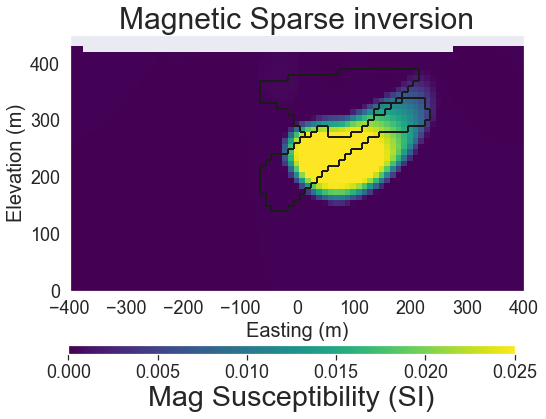

In [13]:
seaborn.set(font='sans-serif')
seaborn.set_style('darkgrid', {'legend.frameon':True})
vmin_mag, vmax_mag = 0, 0.025
fontsize=18
indx = 47
normal = 'Y'
nax=1
mesh_plot = Mesh.TensorMesh([mesh.hx, mesh.hy, mesh.hz], x0="CCN")
mesh_plot.x0[-1] = mesh.x0[-1]
fig, ax = plt.subplots(1, 1, figsize=(10, 5),sharex=False, sharey=False)
fig.subplots_adjust(wspace=0.,hspace=0.)
ax = np.array([ax,ax,ax])

#Mag petro
magplot = mesh_plot.plotSlice(
    maglplq, ax=ax[2], normal=normal,ind=indx,
    clim = [vmin_mag, vmax_mag], pcolorOpts = {'cmap':'viridis'})
ax[2].set_aspect('equal')
ax[2].set_title('Magnetic Sparse inversion', fontsize=1.25*fontsize*(4./3.))
ax[2].set_xlabel('Easting (m)', fontsize=20)
ax[2].set_ylabel('Elevation (m)', fontsize=20)
#ax[1].tick_params(labelbottom=False)  
#ax[2].set_ylabel('')
getBlkOutline(geomodel,mesh_plot,indx,normal, ax[2])

for i in range(len(ax)):
        ax[i].set_xlim([-400,400])
        ax[i].set_ylim([0.,450])
        ax[i].tick_params(labelsize=18)
#ax1.set_xlim([-0.6,0.])
#ax1.set_ylim([0.,0.03])
#plt.tight_layout()

cbaxes_mag = fig.add_axes([.2, 0.0, 0.62, 0.025]) 
cbarmag = fig.colorbar(magplot[0],cbaxes_mag, orientation='horizontal',)
cbarmag.ax.tick_params(labelsize=18)
cbarmag.set_label("Mag Susceptibility (SI)",fontsize=1.2*fontsize*(4./3.))
cbarmag.ax.xaxis.set_label_position('bottom')

plt.tight_layout()


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


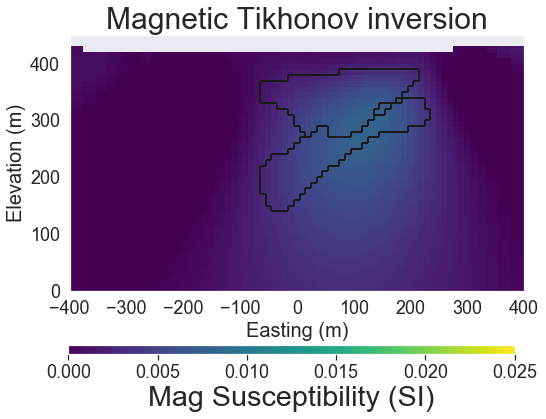

In [12]:
seaborn.set(font='sans-serif')
seaborn.set_style('darkgrid', {'legend.frameon':True})
vmin_grav, vmax_grav = -0.4, 0.0
vmin_mag, vmax_mag = 0, 0.025
fontsize=18
indx = 47
normal = 'Y'
nax=1
mesh_plot = Mesh.TensorMesh([mesh.hx, mesh.hy, mesh.hz], x0="CCN")
mesh_plot.x0[-1] = mesh.x0[-1]
fig, ax = plt.subplots(1, 1, figsize=(10, 5),sharex=False, sharey=False)
fig.subplots_adjust(wspace=0.,hspace=0.)
ax = np.array([ax,ax,ax])

#Mag petro
magplot = mesh_plot.plotSlice(
    magl2, ax=ax[2], normal=normal,ind=indx,
    clim = [vmin_mag, vmax_mag], pcolorOpts = {'cmap':'viridis'})
ax[2].set_aspect('equal')
ax[2].set_title('Magnetic Tikhonov inversion', fontsize=1.25*fontsize*(4./3.))
ax[2].set_xlabel('Easting (m)', fontsize=20)
ax[2].set_ylabel('Elevation (m)', fontsize=20)
#ax[1].tick_params(labelbottom=False)  
#ax[2].set_ylabel('')
getBlkOutline(geomodel,mesh_plot,indx,normal, ax[2])

for i in range(len(ax)):
        ax[i].set_xlim([-400,400])
        ax[i].set_ylim([0.,450])
        ax[i].tick_params(labelsize=18)
#ax1.set_xlim([-0.6,0.])
#ax1.set_ylim([0.,0.03])
#plt.tight_layout()

cbaxes_mag = fig.add_axes([.2, 0.0, 0.62, 0.025]) 
cbarmag = fig.colorbar(magplot[0],cbaxes_mag, orientation='horizontal',)
#cbargrav.set_ticklabels(["1e-5","1e-4","1e-3","1e-2","1e-1"])
cbarmag.ax.tick_params(labelsize=18)
cbarmag.set_label("Mag Susceptibility (SI)",fontsize=1.2*fontsize*(4./3.))
cbarmag.ax.xaxis.set_label_position('bottom')

plt.tight_layout()
